# 目录

- [1.数据准备](#1.数据准备)
- [2.数据清洗](#2.数据清洗)
- [3.推荐情况与游戏时长的关系](#3.推荐情况与游戏时长的关系)
- [4.评测认同人数频率分布](#4.评测认同人数频率分布)
- [5.用户推荐情况预测](#5.用户推荐情况预测)
- [6.情感分析](#6.情感分析)
- [7.词云图](#7.词云图)

# 1.数据准备

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_excel('黑神话悟空用户评论.xlsx')
df.head()

,用户,评测内容,推荐情况,游戏时长,评测价值度认同
0,T1MB3R,"Gorgeous game, when its not freezing. The comb...",不推荐,总时数 1.1 小时,有 6 人觉得这篇评测有价值
1,V.N.,Extremely pretty looking game and the game pla...,推荐,总时数 4.1 小时,有 3 人觉得这篇评测有价值
2,TheSuckLord,"Challenging, cinematic fights. Responsive cont...",推荐,总时数 5.7 小时,有 2 人觉得这篇评测有价值
3,Miu,damn good,推荐,总时数 1.8 小时,有 3 人觉得这篇评测有价值
4,Mao8,"well optimized, fair difficulty, easy to under...",推荐,总时数 11.5 小时,有 4 人觉得这篇评测有价值


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   用户       7999 non-null   object
 1   评测内容     7983 non-null   object
 2   推荐情况     8000 non-null   object
 3   游戏时长     8000 non-null   object
 4   评测价值度认同  8000 non-null   object
dtypes: object(5)
memory usage: 312.6+ KB


# 2.数据清洗

In [4]:
# 处理用户列的缺失值
df['用户'] = df['用户'].fillna('Unknown')

In [5]:
# 将游戏时长转换为数值类型
def extract_and_convert_hours(s):
    num = re.search(r'\d+\.?\d*', s)
    if num:
        return float(num.group())
    return np.nan
df['游戏时长_数值'] = df['游戏时长'].apply(extract_and_convert_hours)
print(df[['游戏时长', '游戏时长_数值']].head())

          游戏时长  游戏时长_数值
0   总时数 1.1 小时      1.1
1   总时数 4.1 小时      4.1
2   总时数 5.7 小时      5.7
3   总时数 1.8 小时      1.8
4  总时数 11.5 小时     11.5


# 3.推荐情况与游戏时长的关系

In [6]:
# 计算平均游戏时长
average_playtime = df['游戏时长_数值'].mean()
print(f"Average Playtime: {average_playtime:.2f} 小时")

Average Playtime: 9.38 小时


In [7]:
# 统计推荐与不推荐的用户数量
recommendation_counts = df['推荐情况'].value_counts()
print(recommendation_counts)

推荐情况
推荐     7626
不推荐     374
Name: count, dtype: int64


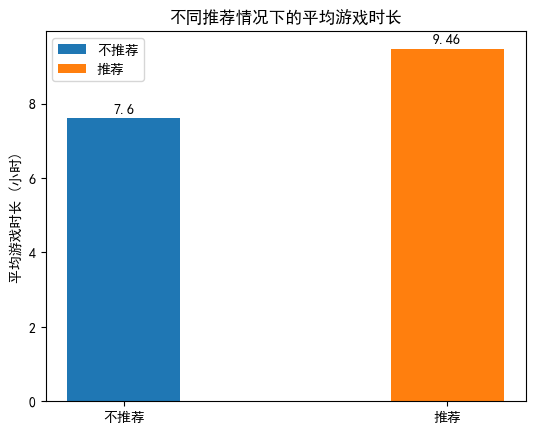

In [8]:
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['simhei']  
plt.rcParams['axes.unicode_minus'] = False  

# 分组分析推荐情况下的平均游戏时长
grouped_recommendations = df.groupby('推荐情况')['游戏时长_数值'].mean().sort_values()
grouped_recommendations_df = grouped_recommendations.reset_index()
grouped_recommendations_df.columns = ['推荐情况', '平均游戏时长']

# 绘制可视化图
fig, ax = plt.subplots()
bar_width = 0.35  
index = range(len(grouped_recommendations_df))  
bars = []
for i, row in grouped_recommendations_df.iterrows():
    bar = plt.bar(index[i], row['平均游戏时长'], width=bar_width, label=row['推荐情况'])
    bars.append(bar)

# 添加数据标签
for bar in bars:
    for rect in bar.patches:
        y_value = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., y_value + 0.1, round(y_value, 2), ha='center', va='bottom')

plt.subplots_adjust(left=0.15)
plt.xticks(index, grouped_recommendations_df['推荐情况'])
plt.ylabel('平均游戏时长 (小时)')
plt.title('不同推荐情况下的平均游戏时长')
plt.legend()
plt.show()

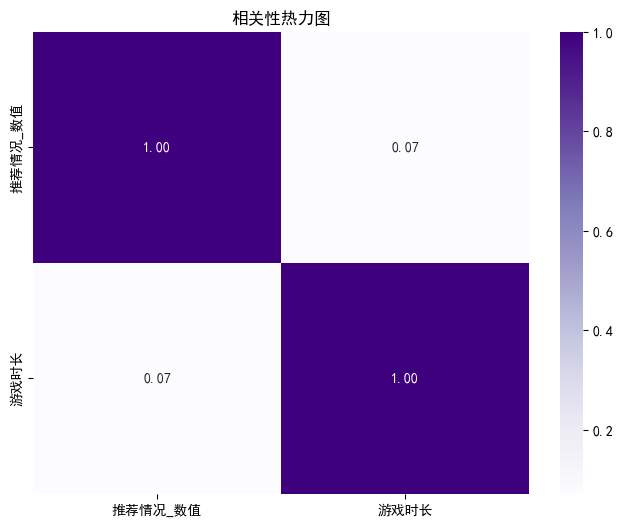

In [9]:
# 游戏时长与推荐情况的相关性
df['游戏时长'] = df['游戏时长_数值']
grouped_means = df.groupby('推荐情况')['游戏时长'].mean().reset_index()
df['推荐情况_数值'] = df['推荐情况'].map({'推荐': 1, '不推荐': 0})
df.dropna(subset=['推荐情况_数值', '游戏时长'], inplace=True)
correlation_matrix = df[['推荐情况_数值', '游戏时长']].corr()

plt.figure(figsize=(8, 6))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Purples', cbar=True)
plt.title('相关性热力图')
plt.show()

# 4.评测认同人数频率分布

In [10]:
# 统计每篇评测的认同人数
def count_agreements(text):
    if pd.isna(text):  
        return None
    parts = text.split('有 ')  
    if len(parts) > 1:  
        try:
            return int(parts[1].split(' ')[0])  
        except ValueError:
            return 0  
    return 0  
df['认同人数'] = df['评测价值度认同'].apply(count_agreements)
value_counts_agreement = df['认同人数'].value_counts()
print(value_counts_agreement)

认同人数
0     7735
2      102
3       58
4       33
5       18
6       16
9        6
7        6
11       5
14       3
13       3
10       2
8        2
16       2
12       1
23       1
15       1
26       1
19       1
33       1
31       1
58       1
38       1
Name: count, dtype: int64


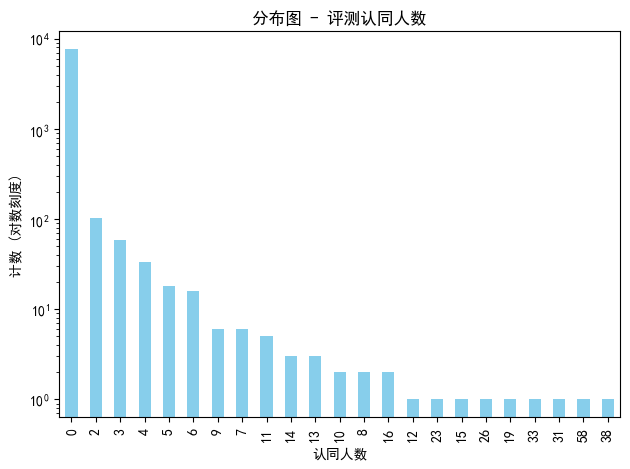

In [11]:
# 转换为对数刻度
plt.figure()
value_counts_agreement.plot(kind='bar', logy=True, color='skyblue')

# 设置图表标题和标签
plt.title('分布图 - 评测认同人数')
plt.xlabel('认同人数')
plt.ylabel('计数 (对数刻度)')

# 显示图表
plt.tight_layout()
plt.show()

有7735篇评测尚未得到大家的认同，这表明大部分评测没有获得认同，或者这些评测是新发布的，还没有得到社区的反馈。 随着认同人数的增加，对应的评测数量显著减少。例如，有102篇评测获得了2个认同，58篇评测获得了3个认同。 由于数据的范围跨越较大，使用对数刻度可以更容易地展示和比较不同数值区间的数据。

# 5.用户推荐情况预测

              precision    recall  f1-score   support

           0       0.90      0.11      0.19        84
           1       0.95      1.00      0.98      1516

    accuracy                           0.95      1600
   macro avg       0.93      0.55      0.58      1600
weighted avg       0.95      0.95      0.93      1600



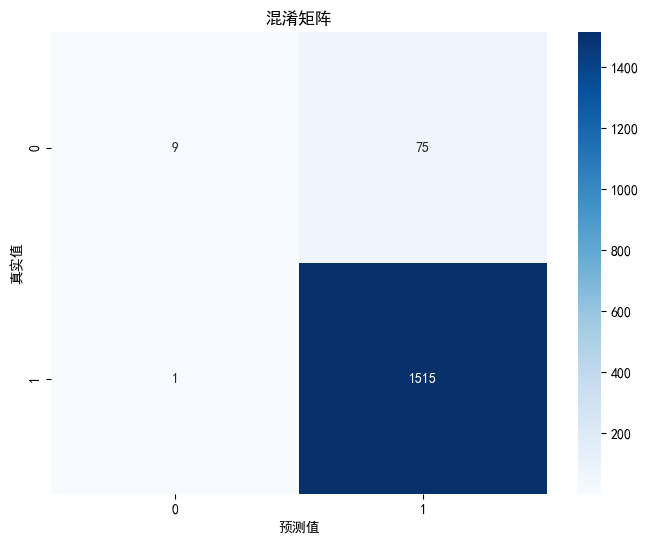

In [12]:
# 将评测内容列中的NaN值替换为一个空字符串
df['评测内容'] = df['评测内容'].fillna('')

# 使用CountVectorizer进行文本向量化
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['评测内容'])

# 将推荐情况转换为数值
y = df['推荐情况'].map({'推荐': 1, '不推荐': 0})

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练模型
model = LogisticRegression()
model.fit(X_train, y_train)

# 模型评估
predictions = model.predict(X_test)
cr = classification_report(y_test, predictions)
cm = confusion_matrix(y_test, predictions)
print(cr)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=True)
plt.xlabel('预测值')
plt.ylabel('真实值')
plt.title('混淆矩阵')
plt.show()


上述使用机器学习中的逻辑回归模型来预测用户的“推荐情况”。根据分类报告，模型在“不推荐”类别（0）上的精确度较高，但召回率很低，表明模型很少预测为“不推荐”，但当它预测为“不推荐”时，这些预测是正确的。 “推荐”类别（1）的召回率很高，表明模型能够识别几乎所有的“推荐”情况，但精确度稍低，意味着可能有一些“不推荐”的情况被错误地预测为“推荐”。整体准确率很高，表明模型在测试集上的预测性能很好。

# 6.情感分析

In [13]:
from snownlp import SnowNLP
# 定义一个函数来计算情感倾向
def sentiment_analysis(text):
    if not text:  
        return None
    s = SnowNLP(text)
    return s.sentiments

# 应用情感分析函数
df['情感倾向'] = df['评测内容'].apply(sentiment_analysis)

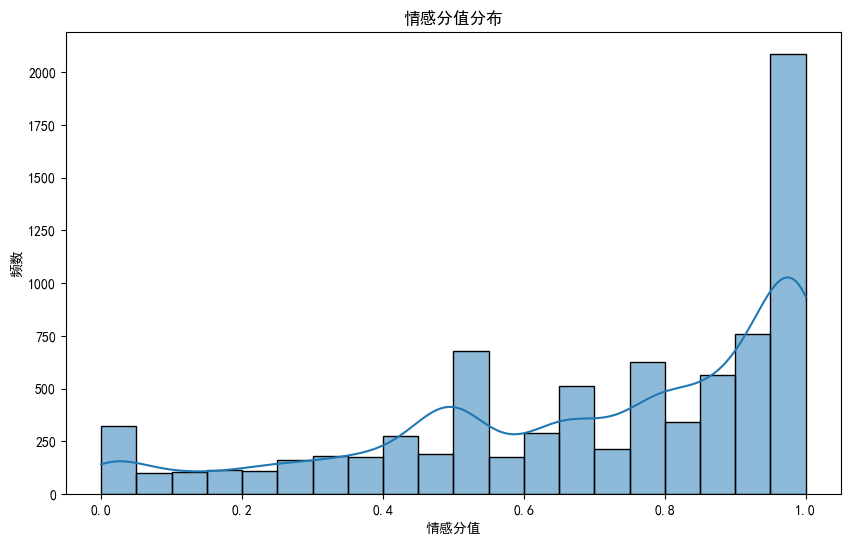

In [14]:
# 绘制情感分值的直方图
plt.figure(figsize=(10, 6))
sns.histplot(df['情感倾向'], bins=20, kde=True)
plt.title('情感分值分布')
plt.xlabel('情感分值')
plt.ylabel('频数')
plt.show()

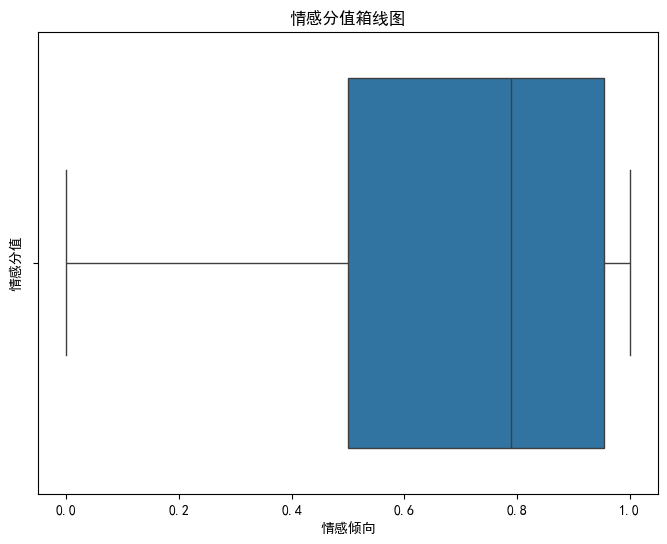

In [15]:
# 绘制情感分值的箱线图
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['情感倾向'])
plt.title('情感分值箱线图')
plt.ylabel('情感分值')
plt.show()

情感分数：分数接近1表示文本具有更强的积极情感倾向。 分数接近0表示文本具有更强的消极情感倾向。 分数为0.5通常被认为是中性的。 从上述可视化图形来看，直方图显示了评测内容更加倾向于积极情感，且消极情感的表达较少。这表明用户普遍比较满意。

# 7.词云图

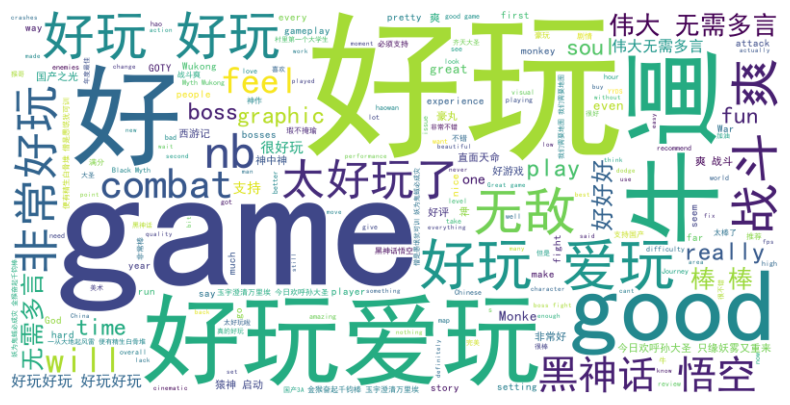

In [16]:
import jieba
from wordcloud import WordCloud

text = ' '.join(df['评测内容'].str.strip())
font_path = r'C:\Windows\Fonts\SimHei.ttf' 
wc = WordCloud(font_path=font_path, width=800, height=400, background_color='white')

# 生成词云图
wc.generate(text)

# 显示词云图
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  
plt.show()